# ROI Extraction

In [1]:
import sys
sys.path.append('../codes')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import pylab as plt

from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

In [5]:
class RegionOfInterest(object):
    def __init__(self, file_name, mode, pickedPeak, mzrange, rtrange, scrange):
        self.file_name = file_name
        self.mode = mode        
        self.pickedPeak = pickedPeak
        self.mzrange = mzrange
        self.rtrange = rtrange
        self.scrange = scrange
        self.peaks = []
        
    def add(self, p):
        if (self.mzrange[0] <= p.mz <= self.mzrange[1]) and (self.rtrange[0] <= p.rt <= self.rtrange[1]):
            self.peaks.append(p)
            
    def __repr__(self):
        return 'ROI %s %s picked %s mz (%.4f-%.4f) rt (%.4f-%.4f) scans (%d-%d)' % (self.file_name, self.mode, self.pickedPeak,
                                                                                    self.mzrange[0], self.mzrange[1],
                                                                                    self.rtrange[0], self.rtrange[1],
                                                                                    self.scrange[0], self.scrange[1])

### 1. Load justin beer data

In [5]:
ds = DataSource()

In [6]:
mzml_path = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\Positive\\samples\\mzML'
ds.load_data(mzml_path)

INFO:DataGenerator:Loading Beer_1_full1.mzML
INFO:DataGenerator:Loading Beer_1_full2.mzML
INFO:DataGenerator:Loading Beer_1_full3.mzML
INFO:DataGenerator:Loading Beer_2_full1.mzML
INFO:DataGenerator:Loading Beer_2_full2.mzML
INFO:DataGenerator:Loading Beer_2_full3.mzML
INFO:DataGenerator:Loading Beer_3_full1.mzML
INFO:DataGenerator:Loading Beer_3_full2.mzML
INFO:DataGenerator:Loading Beer_3_full3.mzML
INFO:DataGenerator:Loading Beer_QC_full1.mzML
INFO:DataGenerator:Loading Beer_QC_full2.mzML
INFO:DataGenerator:Loading Beer_QC_full3.mzML


In [8]:
roi_file = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\rois.csv'
ds.extract_roi(roi_file)

NameError: name 'ds' is not defined

In [8]:
df = pd.read_csv(roi_file)

In [147]:
unique_filenames = df['file'].unique()

### 2. Load ROI data exported from XCMS

In [148]:
all_rois = {} # key: file_name, value: a dict of rois, rois_mzmin, rois_mzmax, rois_rtmin, rois_rtmax
for filename in unique_filenames:
    print('Processing ROIs for %s' % filename)
    rois_data = { 
        'rois': [],
        'mzmin': [],
        'mzmax': [],
        'rtmin': [],
        'rtmax': []
    } 
    
    # convert each row of the dataframe to roi objects
    for idx, row in df.iterrows():
        if (idx % 10000 == 0):
            print('%6d/%6d' % (idx, df.shape[0]))
        file_name = row['file']
        mzmin = row['mzmin']
        mzmax = row['mzmax']
        rtmin = row['rtmin']
        rtmax = row['rtmax']
        scmin = row['scmin']
        scmax = row['scmax']
        pickedPeak = row['pickedPeak']
        mode = row['mode']    
        roi = RegionOfInterest(file_name, mode, pickedPeak, (mzmin, mzmax), (rtmin, rtmax), (scmin, scmax))

        rois_data['rois'].append(roi)
        rois_data['mzmin'].append(mzmin)
        rois_data['mzmax'].append(mzmax)
        rois_data['rtmin'].append(rtmin)
        rois_data['rtmax'].append(rtmax)

    # convert all values to numpy arrays
    rois_data['rois'] = np.array(rois_data['rois'])
    rois_data['mzmin'] = np.array(rois_data['mzmin'])
    rois_data['mzmax'] = np.array(rois_data['mzmax'])
    rois_data['rtmin'] = np.array(rois_data['rtmin'])
    rois_data['rtmax'] = np.array(rois_data['rtmax'])                
    all_rois[filename] = rois_data
    
    print('%d ROIs added' % len(rois_data['rois']))

Processing ROIs for Beer_1_full1.mzML
     0/394970
 10000/394970
 20000/394970
 30000/394970
 40000/394970
 50000/394970
 60000/394970
 70000/394970
 80000/394970
 90000/394970
100000/394970
110000/394970
120000/394970
130000/394970
140000/394970
150000/394970
160000/394970
170000/394970
180000/394970
190000/394970
200000/394970
210000/394970
220000/394970
230000/394970
240000/394970
250000/394970
260000/394970
270000/394970
280000/394970
290000/394970
300000/394970
310000/394970
320000/394970
330000/394970
340000/394970
350000/394970
360000/394970
370000/394970
380000/394970
390000/394970
394970 ROIs added


In [149]:
def get_containing_rois(p, rois_data):
    mzmin_check = rois_data['mzmin'] <= p.mz
    mzmax_check = p.mz <= rois_data['mzmax']
    rtmin_check = rois_data['rtmin'] <= p.rt
    rtmax_check = p.rt <= rois_data['rtmax']
    idx = np.nonzero(mzmin_check & mzmax_check & rtmin_check & rtmax_check)[0]
    rois = rois_data['rois'][idx]
    return rois

In [150]:
for filename in unique_filenames:
    spectra = ds.file_spectra[filename]
    for scan_id, spectrum in spectra.items():
        print('%4d/%d processing spectrum %s' % (scan_id, len(spectra), spectrum))
        rt = ds._get_rt(spectrum)
        for mz, intensity in spectrum.peaks('raw'):
            p = PeakSample(mz, rt, intensity, spectrum.ms_level)            
            rois = get_containing_rois(p, rois_data)
            for roi in rois:
                roi.add(p)            

   0/1112 processing spectrum <__main__.Spectrum object with native ID 1 at 0x2318119b470>
   1/1112 processing spectrum <__main__.Spectrum object with native ID 3 at 0x2319cf5dd30>
   2/1112 processing spectrum <__main__.Spectrum object with native ID 5 at 0x2319cf68518>
   3/1112 processing spectrum <__main__.Spectrum object with native ID 7 at 0x2319cf76358>
   4/1112 processing spectrum <__main__.Spectrum object with native ID 9 at 0x2319cf76390>
   5/1112 processing spectrum <__main__.Spectrum object with native ID 11 at 0x2319cf76c50>
   6/1112 processing spectrum <__main__.Spectrum object with native ID 13 at 0x2319cf82a90>
   7/1112 processing spectrum <__main__.Spectrum object with native ID 15 at 0x2319cf82ac8>
   8/1112 processing spectrum <__main__.Spectrum object with native ID 17 at 0x2319cf8d3c8>
   9/1112 processing spectrum <__main__.Spectrum object with native ID 19 at 0x2319cf9a160>
  10/1112 processing spectrum <__main__.Spectrum object with native ID 21 at 0x2319cf

  89/1112 processing spectrum <__main__.Spectrum object with native ID 179 at 0x2319d16b7f0>
  90/1112 processing spectrum <__main__.Spectrum object with native ID 181 at 0x2319d178390>
  91/1112 processing spectrum <__main__.Spectrum object with native ID 183 at 0x2319d178c88>
  92/1112 processing spectrum <__main__.Spectrum object with native ID 185 at 0x2319d184b38>
  93/1112 processing spectrum <__main__.Spectrum object with native ID 187 at 0x2319d184b70>
  94/1112 processing spectrum <__main__.Spectrum object with native ID 189 at 0x2319d18e4a8>
  95/1112 processing spectrum <__main__.Spectrum object with native ID 191 at 0x2319d19a358>
  96/1112 processing spectrum <__main__.Spectrum object with native ID 193 at 0x2319d19a390>
  97/1112 processing spectrum <__main__.Spectrum object with native ID 195 at 0x2319d19ac88>
  98/1112 processing spectrum <__main__.Spectrum object with native ID 197 at 0x2319d1a77b8>
  99/1112 processing spectrum <__main__.Spectrum object with native ID

 178/1112 processing spectrum <__main__.Spectrum object with native ID 357 at 0x2319d376ef0>
 179/1112 processing spectrum <__main__.Spectrum object with native ID 359 at 0x2319d382be0>
 180/1112 processing spectrum <__main__.Spectrum object with native ID 361 at 0x2319d38d400>
 181/1112 processing spectrum <__main__.Spectrum object with native ID 363 at 0x2319d38dcf8>
 182/1112 processing spectrum <__main__.Spectrum object with native ID 365 at 0x2319d39b518>
 183/1112 processing spectrum <__main__.Spectrum object with native ID 367 at 0x2319d3a73c8>
 184/1112 processing spectrum <__main__.Spectrum object with native ID 369 at 0x2319d3a7400>
 185/1112 processing spectrum <__main__.Spectrum object with native ID 371 at 0x2319d3a7be0>
 186/1112 processing spectrum <__main__.Spectrum object with native ID 373 at 0x2319d3b2518>
 187/1112 processing spectrum <__main__.Spectrum object with native ID 375 at 0x2319d3b2cf8>
 188/1112 processing spectrum <__main__.Spectrum object with native ID

 267/1112 processing spectrum <__main__.Spectrum object with native ID 535 at 0x2319d58cc18>
 268/1112 processing spectrum <__main__.Spectrum object with native ID 537 at 0x2319d59b438>
 269/1112 processing spectrum <__main__.Spectrum object with native ID 539 at 0x2319d59bc18>
 270/1112 processing spectrum <__main__.Spectrum object with native ID 541 at 0x2319d5a7438>
 271/1112 processing spectrum <__main__.Spectrum object with native ID 543 at 0x2319d5a7cc0>
 272/1112 processing spectrum <__main__.Spectrum object with native ID 545 at 0x2319d5b1550>
 273/1112 processing spectrum <__main__.Spectrum object with native ID 547 at 0x2319d5b1d30>
 274/1112 processing spectrum <__main__.Spectrum object with native ID 549 at 0x2319d5be550>
 275/1112 processing spectrum <__main__.Spectrum object with native ID 551 at 0x2319d5bed30>
 276/1112 processing spectrum <__main__.Spectrum object with native ID 553 at 0x2319d5c9550>
 277/1112 processing spectrum <__main__.Spectrum object with native ID

 356/1112 processing spectrum <__main__.Spectrum object with native ID 713 at 0x2319e7715f8>
 357/1112 processing spectrum <__main__.Spectrum object with native ID 715 at 0x2319e77e5c0>
 358/1112 processing spectrum <__main__.Spectrum object with native ID 717 at 0x2319e77e5f8>
 359/1112 processing spectrum <__main__.Spectrum object with native ID 719 at 0x2319e78a5c0>
 360/1112 processing spectrum <__main__.Spectrum object with native ID 721 at 0x2319e78a5f8>
 361/1112 processing spectrum <__main__.Spectrum object with native ID 723 at 0x2319e798550>
 362/1112 processing spectrum <__main__.Spectrum object with native ID 725 at 0x2319e798588>
 363/1112 processing spectrum <__main__.Spectrum object with native ID 727 at 0x2319e7a34a8>
 364/1112 processing spectrum <__main__.Spectrum object with native ID 729 at 0x2319e7a34e0>
 365/1112 processing spectrum <__main__.Spectrum object with native ID 731 at 0x2319e7ae0b8>
 366/1112 processing spectrum <__main__.Spectrum object with native ID

 445/1112 processing spectrum <__main__.Spectrum object with native ID 891 at 0x2319e98b4e0>
 446/1112 processing spectrum <__main__.Spectrum object with native ID 893 at 0x2319e98b518>
 447/1112 processing spectrum <__main__.Spectrum object with native ID 895 at 0x2319e997e48>
 448/1112 processing spectrum <__main__.Spectrum object with native ID 897 at 0x2319e997e80>
 449/1112 processing spectrum <__main__.Spectrum object with native ID 899 at 0x2319e997eb8>
 450/1112 processing spectrum <__main__.Spectrum object with native ID 901 at 0x2319e997ef0>
 451/1112 processing spectrum <__main__.Spectrum object with native ID 903 at 0x2319e9ad5f8>
 452/1112 processing spectrum <__main__.Spectrum object with native ID 905 at 0x2319e9ad630>
 453/1112 processing spectrum <__main__.Spectrum object with native ID 907 at 0x2319e9b95f8>
 454/1112 processing spectrum <__main__.Spectrum object with native ID 909 at 0x2319e9b9630>
 455/1112 processing spectrum <__main__.Spectrum object with native ID

 533/1112 processing spectrum <__main__.Spectrum object with native ID 1067 at 0x2319eb8ce48>
 534/1112 processing spectrum <__main__.Spectrum object with native ID 1069 at 0x2319eb97ba8>
 535/1112 processing spectrum <__main__.Spectrum object with native ID 1071 at 0x2319eb97be0>
 536/1112 processing spectrum <__main__.Spectrum object with native ID 1073 at 0x2319eba3668>
 537/1112 processing spectrum <__main__.Spectrum object with native ID 1075 at 0x2319ebaf320>
 538/1112 processing spectrum <__main__.Spectrum object with native ID 1077 at 0x2319ebaf358>
 539/1112 processing spectrum <__main__.Spectrum object with native ID 1079 at 0x2319ebafe48>
 540/1112 processing spectrum <__main__.Spectrum object with native ID 1081 at 0x2319ebbbb00>
 541/1112 processing spectrum <__main__.Spectrum object with native ID 1083 at 0x2319ebbbb38>
 542/1112 processing spectrum <__main__.Spectrum object with native ID 1085 at 0x2319ebc6668>
 543/1112 processing spectrum <__main__.Spectrum object with

 621/1112 processing spectrum <__main__.Spectrum object with native ID 1243 at 0x2319ed98ef0>
 622/1112 processing spectrum <__main__.Spectrum object with native ID 1245 at 0x2319eda4ba8>
 623/1112 processing spectrum <__main__.Spectrum object with native ID 1247 at 0x2319eda4be0>
 624/1112 processing spectrum <__main__.Spectrum object with native ID 1249 at 0x2319edb05f8>
 625/1112 processing spectrum <__main__.Spectrum object with native ID 1251 at 0x2319edb0ef0>
 626/1112 processing spectrum <__main__.Spectrum object with native ID 1253 at 0x2319edbaba8>
 627/1112 processing spectrum <__main__.Spectrum object with native ID 1255 at 0x2319edbabe0>
 628/1112 processing spectrum <__main__.Spectrum object with native ID 1257 at 0x2319edc65f8>
 629/1112 processing spectrum <__main__.Spectrum object with native ID 1259 at 0x2319edc6ef0>
 630/1112 processing spectrum <__main__.Spectrum object with native ID 1261 at 0x2319edd2710>
 631/1112 processing spectrum <__main__.Spectrum object with

 709/1112 processing spectrum <__main__.Spectrum object with native ID 1419 at 0x2319efb2160>
 710/1112 processing spectrum <__main__.Spectrum object with native ID 1421 at 0x2319efb2198>
 711/1112 processing spectrum <__main__.Spectrum object with native ID 1423 at 0x2319efb2e10>
 712/1112 processing spectrum <__main__.Spectrum object with native ID 1425 at 0x2319efbd748>
 713/1112 processing spectrum <__main__.Spectrum object with native ID 1427 at 0x2319efca710>
 714/1112 processing spectrum <__main__.Spectrum object with native ID 1429 at 0x2319efca748>
 715/1112 processing spectrum <__main__.Spectrum object with native ID 1431 at 0x2319efd6710>
 716/1112 processing spectrum <__main__.Spectrum object with native ID 1433 at 0x2319efd6748>
 717/1112 processing spectrum <__main__.Spectrum object with native ID 1435 at 0x2319efd6780>
 718/1112 processing spectrum <__main__.Spectrum object with native ID 1437 at 0x2319efe1ef0>
 719/1112 processing spectrum <__main__.Spectrum object with

 797/1112 processing spectrum <__main__.Spectrum object with native ID 1595 at 0x2319f1b3e10>
 798/1112 processing spectrum <__main__.Spectrum object with native ID 1597 at 0x2319f1be668>
 799/1112 processing spectrum <__main__.Spectrum object with native ID 1599 at 0x2319f1bef98>
 800/1112 processing spectrum <__main__.Spectrum object with native ID 1601 at 0x2319f1ca7b8>
 801/1112 processing spectrum <__main__.Spectrum object with native ID 1603 at 0x2319f1d5400>
 802/1112 processing spectrum <__main__.Spectrum object with native ID 1605 at 0x2319f1d5438>
 803/1112 processing spectrum <__main__.Spectrum object with native ID 1607 at 0x2319f1d5eb8>
 804/1112 processing spectrum <__main__.Spectrum object with native ID 1609 at 0x2319f1e16d8>
 805/1112 processing spectrum <__main__.Spectrum object with native ID 1611 at 0x2319f1e1fd0>
 806/1112 processing spectrum <__main__.Spectrum object with native ID 1613 at 0x2319f1ef7f0>
 807/1112 processing spectrum <__main__.Spectrum object with

 885/1112 processing spectrum <__main__.Spectrum object with native ID 1771 at 0x2319f3beef0>
 886/1112 processing spectrum <__main__.Spectrum object with native ID 1773 at 0x2319f3c9748>
 887/1112 processing spectrum <__main__.Spectrum object with native ID 1775 at 0x2319f3d6048>
 888/1112 processing spectrum <__main__.Spectrum object with native ID 1777 at 0x2319f3d6828>
 889/1112 processing spectrum <__main__.Spectrum object with native ID 1779 at 0x2319f3e16d8>
 890/1112 processing spectrum <__main__.Spectrum object with native ID 1781 at 0x2319f3e1710>
 891/1112 processing spectrum <__main__.Spectrum object with native ID 1783 at 0x2319f3e1ef0>
 892/1112 processing spectrum <__main__.Spectrum object with native ID 1785 at 0x2319f3ee828>
 893/1112 processing spectrum <__main__.Spectrum object with native ID 1787 at 0x2319f3fb128>
 894/1112 processing spectrum <__main__.Spectrum object with native ID 1789 at 0x2319f3fb160>
 895/1112 processing spectrum <__main__.Spectrum object with

 973/1112 processing spectrum <__main__.Spectrum object with native ID 1947 at 0x2319f5c9e10>
 974/1112 processing spectrum <__main__.Spectrum object with native ID 1949 at 0x2319f5d3630>
 975/1112 processing spectrum <__main__.Spectrum object with native ID 1951 at 0x2319f5d3f28>
 976/1112 processing spectrum <__main__.Spectrum object with native ID 1953 at 0x2319f5de748>
 977/1112 processing spectrum <__main__.Spectrum object with native ID 1955 at 0x2319f5def28>
 978/1112 processing spectrum <__main__.Spectrum object with native ID 1957 at 0x2319f5eb9e8>
 979/1112 processing spectrum <__main__.Spectrum object with native ID 1959 at 0x2319f5eba20>
 980/1112 processing spectrum <__main__.Spectrum object with native ID 1961 at 0x2319f5f76a0>
 981/1112 processing spectrum <__main__.Spectrum object with native ID 1963 at 0x2319f5f7e80>
 982/1112 processing spectrum <__main__.Spectrum object with native ID 1965 at 0x2319f601710>
 983/1112 processing spectrum <__main__.Spectrum object with

1061/1112 processing spectrum <__main__.Spectrum object with native ID 2123 at 0x2319f7de668>
1062/1112 processing spectrum <__main__.Spectrum object with native ID 2125 at 0x2319f7de6a0>
1063/1112 processing spectrum <__main__.Spectrum object with native ID 2127 at 0x2319f7def28>
1064/1112 processing spectrum <__main__.Spectrum object with native ID 2129 at 0x2319f7eb860>
1065/1112 processing spectrum <__main__.Spectrum object with native ID 2131 at 0x2319f7f6080>
1066/1112 processing spectrum <__main__.Spectrum object with native ID 2133 at 0x2319f7f6860>
1067/1112 processing spectrum <__main__.Spectrum object with native ID 2135 at 0x2319f8035c0>
1068/1112 processing spectrum <__main__.Spectrum object with native ID 2137 at 0x2319f8035f8>
1069/1112 processing spectrum <__main__.Spectrum object with native ID 2139 at 0x2319f803f28>
1070/1112 processing spectrum <__main__.Spectrum object with native ID 2141 at 0x2319f80f748>
1071/1112 processing spectrum <__main__.Spectrum object with

In [151]:
save_obj(all_rois, '../models/all_rois.p')

### Plot some ROIs we found

In [6]:
all_rois = load_obj('../models/all_rois.p')

In [7]:
file_name = list(all_rois.keys())[0]

In [8]:
rois_data = all_rois[file_name]

In [9]:
for roi in rois_data['rois'][0:10]:
    mzs = [p.mz for p in roi.peaks]
    rts = [p.rt for p in roi.peaks]
    intensities = [p.intensity for p in roi.peaks]
    print(mzs)
    print(rts)
    print(intensities)
    print(roi.pickedPeak)
    print()

[194.08082580566406, 194.080810546875, 194.08213806152344, 194.0812530517578]
[2.00315, 3.28365, 3.28365, 4.54815]
[4740.470703125, 9069.8251953125, 10139.1767578125, 12427.2353515625]
False

[202.8921661376953, 202.8919219970703, 202.89227294921875]
[0.355022, 2.00315, 3.28365]
[2574.402099609375, 22355.4921875, 9215.2724609375]
False

[236.16392517089844, 236.16439819335938, 236.16436767578125, 236.1643524169922]
[0.355022, 2.00315, 3.28365, 4.54815]
[2170.17919921875, 8184.88232421875, 9160.5107421875, 8481.1396484375]
False

[313.17498779296875, 313.1757507324219, 313.1754455566406, 313.17620849609375]
[0.355022, 2.00315, 3.28365, 4.54815]
[2724.492431640625, 8393.7001953125, 17343.486328125, 24698.5859375]
False

[500.7229919433594, 500.72576904296875, 500.7237854003906, 500.7248229980469]
[0.355022, 2.00315, 3.28365, 4.54815]
[3214.173095703125, 8849.1630859375, 5878.91796875, 9234.8984375]
False

[738.6577758789062, 738.65771484375, 738.6568603515625, 738.6552124023438]
[0.35502

In [16]:
true_rois = [roi for roi in rois_data['rois'] if roi.pickedPeak]
false_rois = [roi for roi in rois_data['rois'] if not roi.pickedPeak]

In [17]:
print(len(true_rois))
print(len(false_rois))

78140
316830


In [41]:
def plot_roi(roi_list, min_length, title):
    count = 0
    for roi in roi_list:
        mzs = [p.mz for p in roi.peaks]
        rts = [p.rt for p in roi.peaks]
        intensities = [p.intensity for p in roi.peaks]
        if len(rts) > min_length and rts[0] > 180:
            plt.plot(rts, intensities)
            plt.xlabel('RT')
            plt.ylabel('Intensity')
            plt.title(title)
            plt.show()
            count += 1
            if count >= 3:
                break

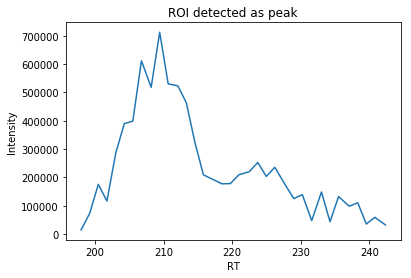

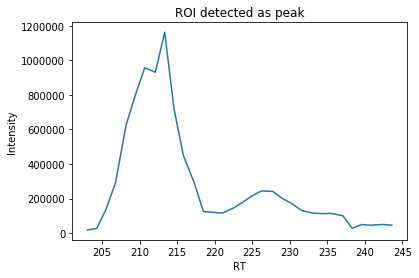

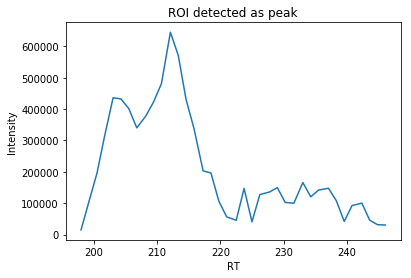

In [42]:
plot_roi(true_rois, 30, 'ROI detected as peak')

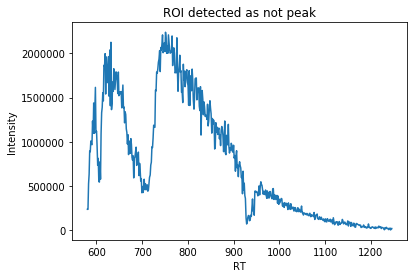

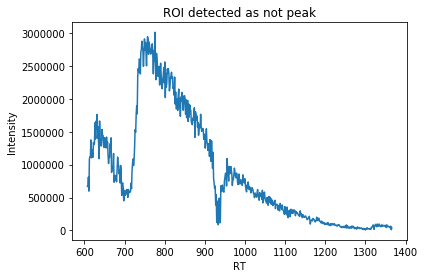

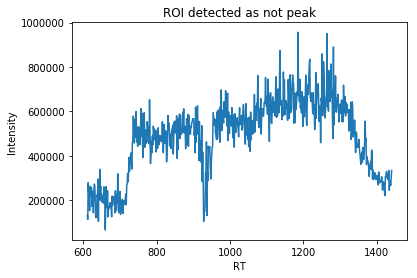

In [45]:
plot_roi(false_rois, 500, 'ROI detected as not peak')